In [30]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import interpolate as interp
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats
import scripts.get_namelist as nml
%matplotlib inline
%config InlineBackend.figure_format = 'png'

from scripts.common import *

fs = 12

def plot_TKEBudget(reader, savename=''):
    #namelist = ('rho_bar', 'tke', 'TKE_rate','dissipation', 'dissipation_num', \
    #            'p_dil_fluct', 'fluct_p_dil', 'production','baropycnal', 'u_tilde', 'u_pprime_bar')

    namelist = ('TKE_rate','dissipation', 'dissipation_num','diss_mass_flux', \
                'p_dil_fluct', 'fluct_p_dil', 'production','baropycnal')
    ddt_tke, dissipation, num_dissipation, diss_mass_flux, \
    p_dil, f_p_dil, production, baropycnal = reader.readData(namelist)

    variables = {r'$\partial \bar{\rho} \tilde{k} / \partial t$': ddt_tke,\
                 r'Dissipation': dissipation,\
                 r'Numerical dissipation': num_dissipation,\
                 r'Mass flux': diss_mass_flux,\
                 r'Pressure dilatation': p_dil,\
                 r'Fluctuation pressure dilatation': f_p_dil,\
                 r'Production': production,\
                 r'Baropycnal': baropycnal}
    
    plt.figure(figsize=(8,4), dpi=100)
    for i, var in enumerate(variables):
        im = plt.plot(y[0,:,0],variables[var][0, :, 0],label=var)
    plt.xlabel(r'$y$', fontsize=fs)        
    plt.tick_params(labelsize=fs)
    plt.tight_layout()
    plt.legend(namelist)
    
    if savename:
        plt.savefig(savename, dpi=500)
        plt.close(fig)
        print "Saved plot to " + savename
def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)

    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    domega = dat[:,2]
    return time,dtheta,domega 

def plot_one(dirname, reader, qname, steps):
    
    time,dtheta,domega = growth_rates(dirname+'/shearlayer_')
    
    plt.figure(figsize=(8,4), dpi=100)
    
    ymax = 10
    qplot_mean = 0.
    yplot_mean = np.linspace(-ymax,ymax,Ny/2)
    
    for step in steps:
        reader.step = step
        t = reader.time
        q = reader.readData(qname)
        d = dtheta[np.argmin(abs(time-t))]
        qplot = np.squeeze(np.array(q))*inp.du**3
        if (qname!='rho_bar'): qplot /= d
        yplot = y[0,:,0]/d
        plt.plot(yplot,qplot,label="t = {}".format(t),alpha=0.4)
        
        # interp onto the mean grid for plotting
        qplot_mean += np.interp(yplot_mean, yplot, qplot)
        
    plt.plot(yplot_mean,qplot_mean/np.size(steps),'k-',label='Mean')
    plt.xlabel(r'$\eta$', fontsize=fs)        
    plt.tick_params(labelsize=fs)
    plt.grid(True)
    plt.tight_layout()
    plt.xlim([-ymax,ymax])
    plt.legend(bbox_to_anchor=(1.5, 0.3))

def plot_all(dirname, reader, steps):
    
    qnames = ('TKE_rate','production','p_dil_fluct', 'fluct_p_dil','baropycnal',\
              'diss_fluct','diss_mass_flux','dissipation_num')
    qnames_nice = (r'TKE rate: $\dot{k}$', 
                   r'Production: -$\overline{\rho} \tilde{R}_{ij} \tilde{u}_{i,j}$ ',
                   r'Pressure fluctuation-dilatation: $\overline{pu^{\prime\prime}_{i,i}}$',
                   r'Fluctuating pressure fluctuation-dilatation correlation: $\overline{p^\prime u^{\prime\prime}_{i,i}}$',
                   r'Baropycnal: -$\overline{u^{\prime\prime}_ip^\prime_{,i}}$',
                   r'Dissipation: $\overline{\tau_{ij}u^{\prime\prime}_{i,j}}$',
                   r'Mass flux: $\overline{u^{\prime\prime}_{i}}\overline{\tau}_{ij,j}$',
                   'Dissipation (filter)'
                  )
    time,dtheta,domega = growth_rates(dirname+'/shearlayer_')
    
    nvars = len(qnames)
    ymax = Ny/4
    qplot_mean = np.zeros([8,Ny/2])
    yplot_mean = np.linspace(Ny/2-ymax,Ny/2+ymax,Ny/2)
    
    plt.figure(figsize=(8,4), dpi=100)
    for step in steps:
        reader.step = step
        t = reader.time
        q = reader.readData(qnames)
        d = dtheta[np.argmin(abs(time-t))]
        qplot = np.squeeze(np.array(q))# / d #* inp.du**2 << add this for scaling
        yplot = y[0,:,0]#/d
        for idx in range(0,nvars):
            qplot_mean[idx,:] += np.interp(yplot_mean, yplot, qplot[idx,:])
        
    qplot_mean = qplot_mean/(np.size(steps))
    for idx in range(0,nvars):        
        if 'diss' in qnames[idx]: 
            qplot_mean[idx,:] = -qplot_mean[idx,:]
        if 'TKE_rate' in qnames[idx]: 
            qplot_mean[idx,:] = -qplot_mean[idx,:]
        plt.plot(yplot_mean,qplot_mean[idx,:],label=qnames_nice[idx])    
    resid = np.squeeze(np.sum(qplot_mean,axis=0))
    plt.plot(yplot_mean,resid,'k-',label='Residual')
    
    plt.xlabel(r'$\eta$', fontsize=fs)        
    plt.tick_params(labelsize=fs)
    plt.grid(True)
    plt.tight_layout()
#     plt.xlim([-ymax,ymax])
    plt.legend(bbox_to_anchor=(0.7, 2))

In [147]:
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/'

filename_prefix = directory + '/TKEBudget_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
x, y, z = reader.readCoordinates()
ymin, ymax = y[0,0,0], y[-1,-1,-1]
Ny = np.shape(y)[1]
inp = nml.inputs(directory,verbose=True)

steps = sorted(reader.steps)
print("Steps: {}".format(steps))

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 30, 32, 34, 36, 38, 40, 42, 44, 50, 54, 58, 62, 66, 70, 74]


num/resolved: 0.102958719906
(2.0, 7.0)


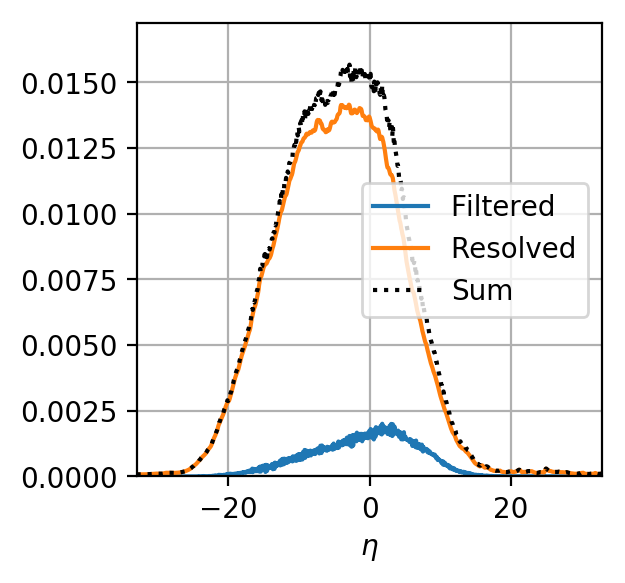

In [136]:
def get_bounds(f,y,thresh=0.01):
    fmax = np.amax(f)
    imax = np.argmax(f)
    f1 = f[:imax]
    f2 = f[imax:]
    i1 = np.argmin(abs(f1-thresh*fmax))
    i2 = np.argmin(abs(f2[::-1]-thresh*fmax))
    return max(abs(y[i1]),abs(y[i2]))

def plot_diss(directory,reader):
    time,dlist,rate = growth_rates(directory+'/shearlayer_')
    t = reader.time
    dtheta = dlist[np.argmin(abs(time-t))]

    diss_num = np.squeeze(reader.readData('dissipation_num'))
    diss = np.squeeze(reader.readData('dissipation'))

    yplot = y[0,:,0]/dtheta
    plt.figure(figsize=(3,3),dpi=200)
    plt.plot(yplot,diss_num,label='Filtered')
    plt.plot(yplot,diss,label='Resolved')
    plt.plot(yplot,diss_num+diss,'k:',label='Sum')
    plt.grid(True)
    plt.legend()
    plt.xlabel(r'$\eta$')
    
    int1 = sum(diss_num[100:-100])
    int2 = sum(diss[100:-100])
    print('num/resolved: {}'.format(int1/int2))
    
    ymax = get_bounds(diss[100:-100],yplot,thresh=0.02)
    plt.xlim([-ymax,ymax])
    dmax = np.amax(diss[100:-100]+diss_num[100:-100])
    plt.ylim([0,dmax*1.1])


reader.step = max(steps)
plot_diss(directory,reader)
print(inp.Mc,inp.rr)
plt.savefig(directory+'/img/diss_num.png',bbox_inches='tight',dpi=200)

num/resolved: 0.00765822615454
(0.2, 1.0, 1010.0)
num/resolved: 0.0534145735385
(0.4, 1.0, 481.70000000000005)
num/resolved: 0.10363591383
(0.8, 1.0, 160.3)
num/resolved: 0.102998958009
(1.2, 1.0, 122.95000000000002)
num/resolved: 0.0972911287779
(1.6, 1.0, 23.500000000000004)
num/resolved: 0.0778128081442
(2.0, 1.0, 134.60000000000005)
Done


<Figure size 750x450 with 0 Axes>

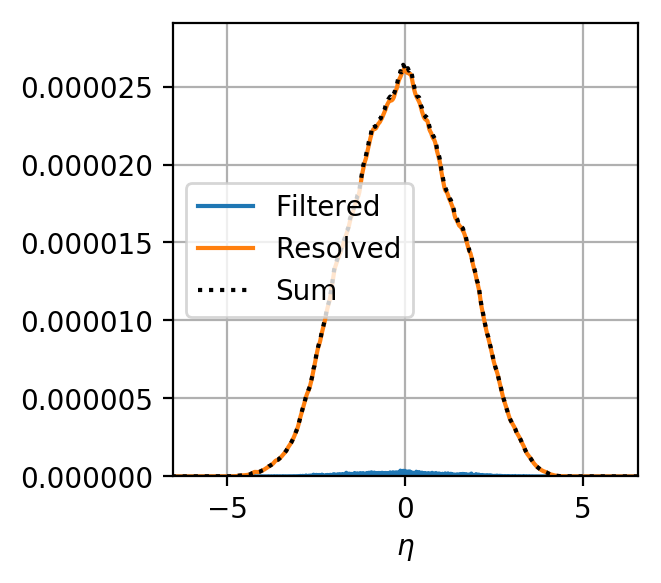

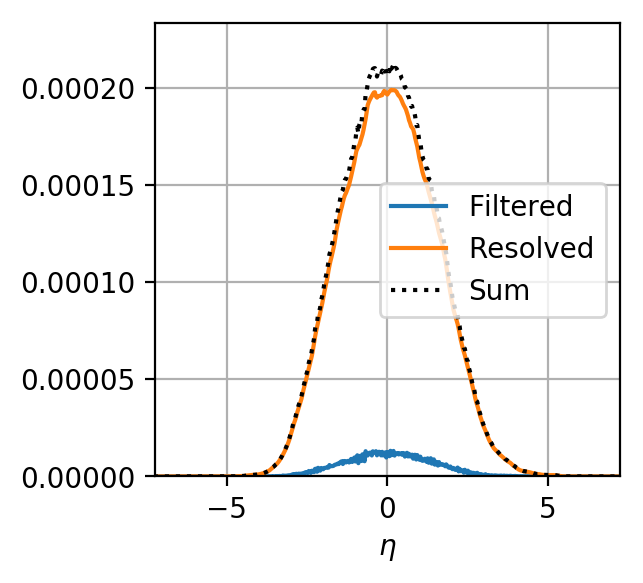

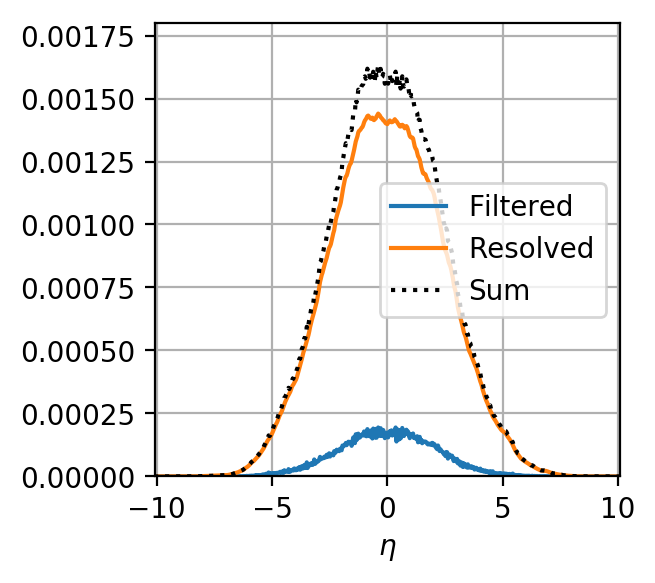

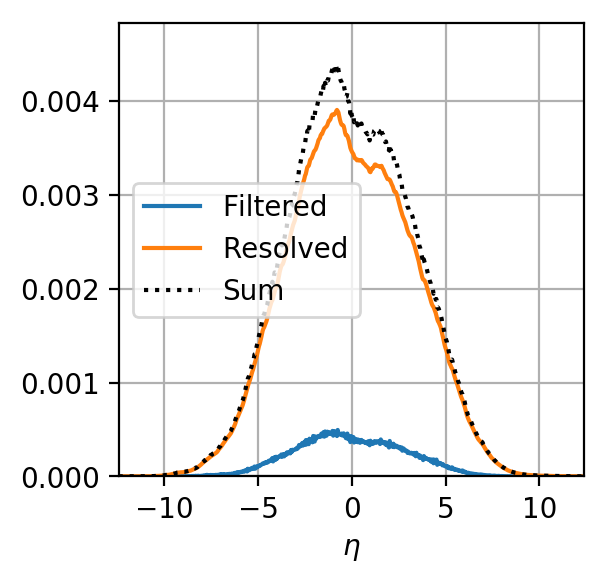

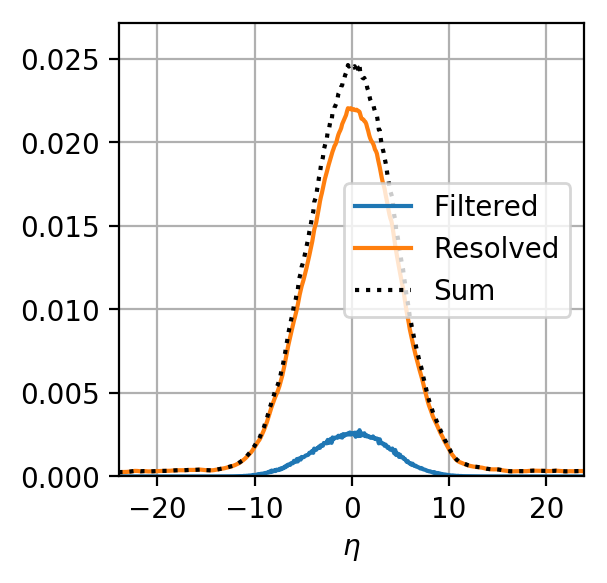

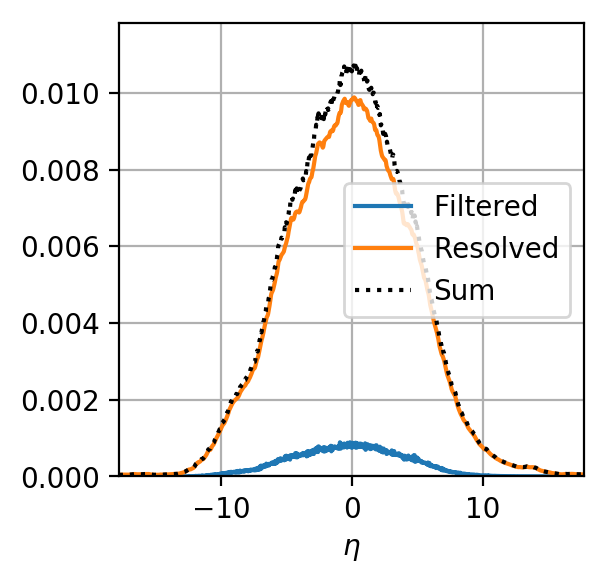

In [137]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    filename_prefix = directory + '/TKEBudget_'
    reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
    reader.step = max(reader.steps)
    plot_diss(directory,reader)
    print(inp.Mc,inp.rr,reader.time)
    plt.savefig(directory+'/img/diss_num.png',bbox_inches='tight',dpi=200)

print('Done')

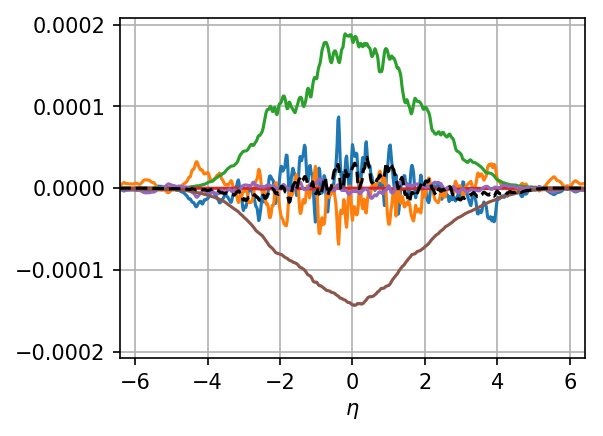

In [152]:
def plot_TKEB(directory,reader):
    time,dlist,rate = growth_rates(directory+'/shearlayer_')
    inp = nml.inputs(directory,verbose=False)
    t = reader.time
    dtheta = dlist[np.argmin(abs(time-t))]
    yplot = y[0,:,0]/dtheta

    plt.figure(figsize=(4,3),dpi=150)
    dat = np.squeeze(reader.readData('TKE_rate'))/inp.du**3; plt.plot(yplot,-dat,label='dk/dt'); resid = -dat;
    dat = np.squeeze(reader.readData('trans_conv'))/inp.du**3; resid -= dat;
    dat = np.squeeze(reader.readData('trans_turb'))/inp.du**3; plt.plot(yplot,dat,label='T'); resid += dat;
    dat = np.squeeze(reader.readData('production'))/inp.du**3; prod=dat; plt.plot(yplot,dat,label='P'); resid += dat;
    dat = np.squeeze(reader.readData('baropycnal'))/inp.du**3; plt.plot(yplot,dat,label='B'); resid += dat;
    dat = np.squeeze(reader.readData('fluct_p_dil'))/inp.du**3; plt.plot(yplot,dat,label=r'$\Pi$'); resid += dat;
    dat = np.squeeze(reader.readData('dissipation'))/inp.du**3; diss=-dat; plt.plot(yplot,-dat,label=r'$D+D^f$'); resid -= dat;
    dat = np.squeeze(reader.readData('dissipation_num'))/inp.du**3; resid -= dat;
    plt.plot(yplot,resid,'k--',label='Residual')

    ymax = get_bounds(abs(diss[100:-100]),yplot,thresh=0.05)
    plt.xlim([-ymax,ymax])
    pmax = np.amax(prod)*1.1
    plt.ylim([-pmax,pmax])
    plt.xlabel(r'$\eta$')
    #plt.legend(bbox_to_anchor=(0.65,1))
    plt.grid(True)

reader.step = steps[-10]#max(steps)
plot_TKEB(directory,reader)
plt.savefig(directory+'/img/TKEB.png',dpi=200,bbox_inches='tight')

(0.2, 1.0, 1010.0)
(0.4, 1.0, 481.70000000000005)
(0.8, 1.0, 160.3)
(1.2, 1.0, 122.95000000000002)
(1.6, 1.0, 23.500000000000004)
(2.0, 1.0, 134.60000000000005)
Done


<Figure size 750x450 with 0 Axes>

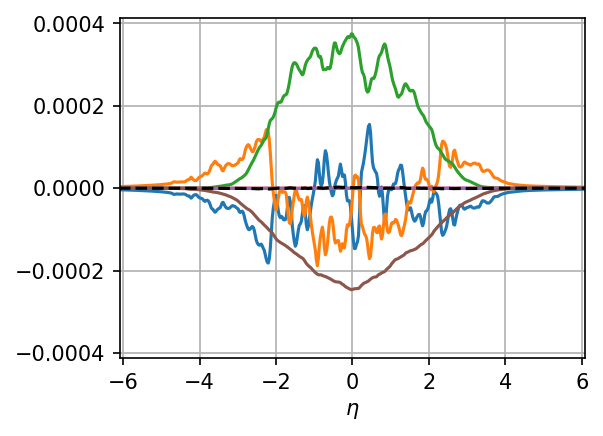

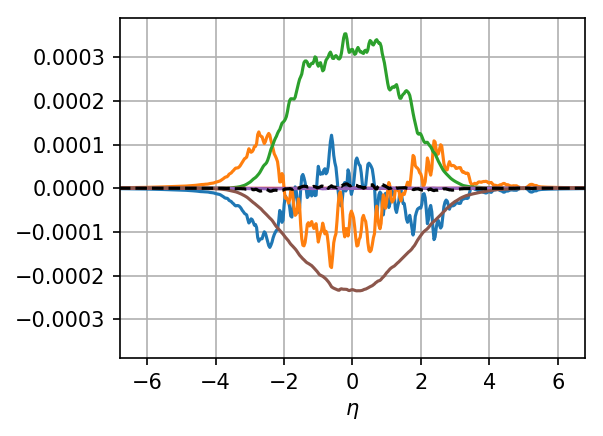

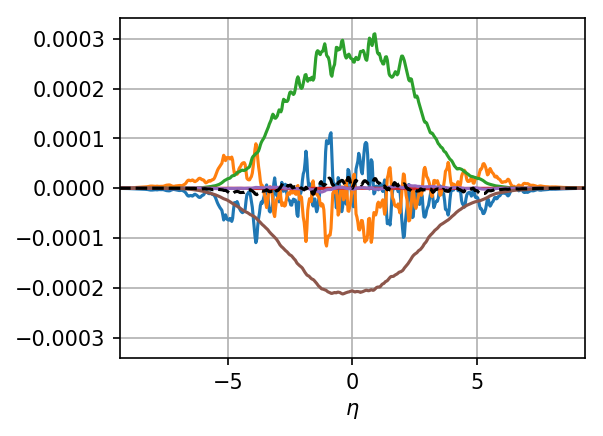

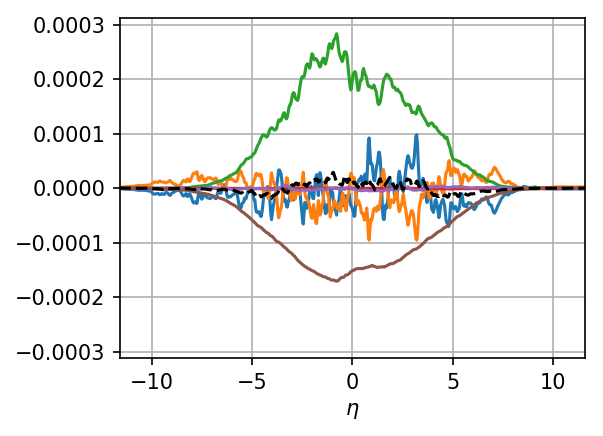

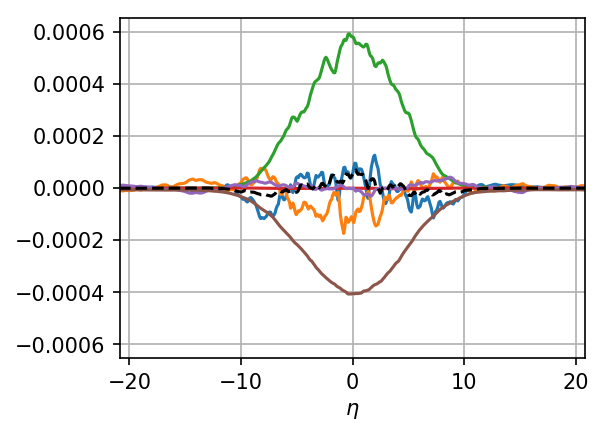

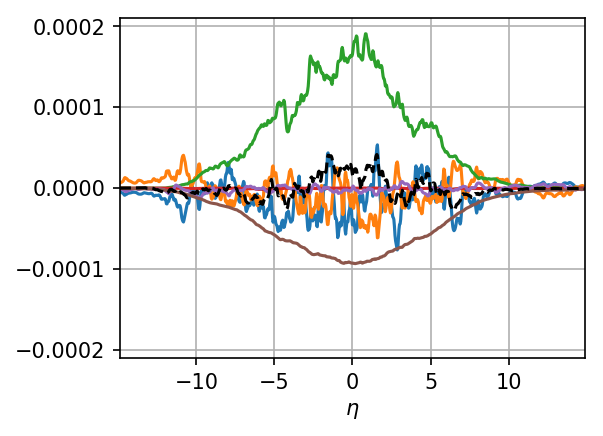

In [146]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(directory,verbose=False)
    filename_prefix = directory + '/TKEBudget_'
    reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
    steps =  sorted(reader.steps)
    reader.step = steps[-1]
    plot_TKEB(directory,reader)
    print(inp.Mc,inp.rr,reader.time)
    plt.savefig(directory+'/img/TKEB.png',bbox_inches='tight',dpi=200)

print('Done')